# False Positive Brand Classifier - EDA & Feature Engineering

This notebook focuses on exploratory data analysis and feature engineering for the FP classifier. It compares multiple feature engineering approaches and exports the best transformer for use in model selection.

## Objective
Develop feature engineering pipeline that can distinguish between articles that genuinely mention sportswear brands vs false positives (e.g., "Puma" the animal, "Patagonia" the region).

**Key Insight: This is a recall-focused problem.**
- **Missing a real sportswear article (low recall) = BAD** - we lose the article forever
- **Letting through a false positive (low precision) = OK** - LLM can catch it later

We optimize for **F2 score** which weights recall 2x higher than precision.

## Contents
1. [Setup](#setup)
2. [Data Loading](#1-data-loading)
3. [Target Variable Analysis](#2-target-variable-analysis) (ALL DATA - for stratification)
4. [Data Preprocessing & Split](#3-data-preprocessing--split)
5. [Exploratory Data Analysis](#4-exploratory-data-analysis) (TRAINING DATA ONLY)
6. [Feature Engineering Comparison](#5-feature-engineering-comparison)
   - 5.1 [Feature Transformer Hyperparameter Tuning](#51-feature-transformer-hyperparameter-tuning)
7. [Pipeline Export](#6-pipeline-export)
8. [Summary](#7-summary)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    split_train_val_test,
)
from src.fp1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.fp1_nb.preprocessing import (
    clean_text,
    create_text_features,
    SPORTSWEAR_VOCAB,
)
from src.fp1_nb.feature_transformer import FPFeatureTransformer

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
TARGET_COL = 'is_sportswear'
LABEL_NAMES = ['Not Sportswear (FP)', 'Sportswear']
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.6, 0.2, 0.2
RANDOM_STATE = 42
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading

In [2]:
# Load the FP training data
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
df = load_jsonl_data(DATA_PATH)

Loaded 1,005 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 7.26 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,source_name,category,is_sportswear,source,fp_reason
0,4c227d4f-e315-4ff6-bc91-fef52fd8e732,MM6 Maison Margiela x Salomon XT - MM6 & ACS Pro Fall 2025 Release Date,"Ever since their debut collaboration in 2022 featuring the Rihanna-approved Cross Low model, MM6...",[Salomon],wwd.com,[],1,skipped,NaN
1,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],insideretail.asia,[],1,labeled,NaN
2,485e193a-3f30-4f1c-855e-a947681b2cbf,Tracy McGrady Says Kobe Leaving Adidas Helped Him Get a Bigger Deal | The Complex Sneakers Podcast,"Complex's\n\nThe Complex Sneakers Show\n\nSeason 17\n\nDecember 12, 2025\n\nTracy McGrady Says K...",[Adidas],complex.com,[],1,skipped,NaN
3,10e8ecbc-0625-4aaa-b5f4-e0f4ae02527c,Where to buy Nike Air Force 1 07 Mid Flax sneakers releasing Oct . 8,"Your favorite Nike street style shoes are getting a refresh that’ll add a crisp, neutral look to...",[Nike],mlive.com,[],1,skipped,NaN
4,04a3817e-38c5-4b62-a678-6eaf49a458c5,"Prime Day competitor sales : The best deals from Walmart , Wayfair , Lululemon and other Amazon ...","As a participant in multiple affiliate marketing programs, Localish will earn a commission for c...",[Lululemon],abc7news.com,[],1,skipped,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     1005 non-null   object
 1   title          1005 non-null   object
 2   content        1005 non-null   object
 3   brands         1005 non-null   object
 4   source_name    1005 non-null   object
 5   category       1005 non-null   object
 6   is_sportswear  1005 non-null   int64 
 7   source         1005 non-null   object
 8   fp_reason      142 non-null    object
dtypes: int64(1), object(8)
memory usage: 70.8+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id         0
title              0
content            0
brands             0
source_name        0
category           0
is_sportswear      0
source             0
fp_reason        863
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled           627
skipped           236
false_positive    142
Name: count, dtype: int64


## 2. Target Variable Analysis (ALL DATA)

This analysis uses the full dataset to understand class imbalance before splitting. This is necessary to inform our stratification strategy.

TARGET VARIABLE ANALYSIS

Total samples: 1,005

Class distribution:
  Not Sportswear (FP): 142 (14.1%)
  Sportswear: 863 (85.9%)

Imbalance ratio: 6.08:1

[WARNING] Dataset is imbalanced (ratio >= 5.0)
Consider using:
  - Stratified sampling for train/val/test splits
  - Class weights or oversampling/undersampling
  - Appropriate metrics (PR-AUC, F1) over accuracy


Figure saved to images/fp_target_distribution.png


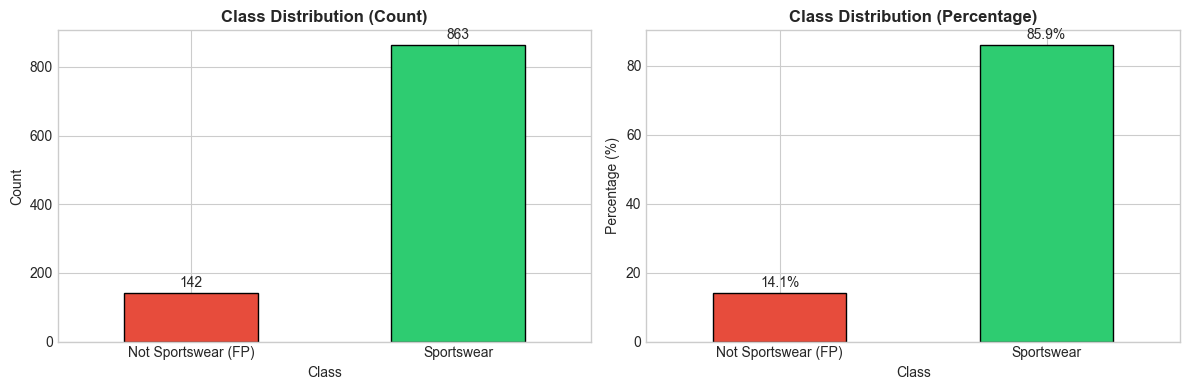

In [7]:
# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/fp_target_distribution.png'
)

## 3. Data Preprocessing & Train/Val/Test Split

We preprocess the text data first (creating text_features), then split into train/val/test sets. All subsequent EDA and feature engineering will use ONLY the training data to prevent data leakage. The validation dataset is used for feature engineering selection. The test data set is NOT used in this notebook.

In [8]:
# Create text features BEFORE splitting
# This combines title, brands, content, and metadata (source, category) into a single cleaned text field
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"\nRecords with empty text features: {empty_texts}")
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records after removing empty: {len(df)}")

Text features created!
Sample:
wwd.com mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners ...

Records with empty text features: 0


In [9]:
# Split with stratification
train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Extract features and targets
X_train = train_df['text_features']
y_train = train_df[TARGET_COL]

X_val = val_df['text_features']
y_val = val_df[TARGET_COL]

# Extract metadata for discrete metadata features
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()
val_source_names = val_df['source_name'].tolist()
val_categories = val_df['category'].tolist()

print(f"\nDataset sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")

TRAIN/VALIDATION/TEST SPLIT

Total samples: 1,005

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      603 (60.0%)
  Validation: 201 (20.0%)
  Test:       201 (20.0%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 85.9%, 0: 14.1%
  Val: 1: 85.6%, 0: 14.4%
  Test: 1: 86.1%, 0: 13.9%

Dataset sizes:
  Train: 603 samples
  Val:   201 samples


## 4. Exploratory Data Analysis (TRAINING DATA ONLY)

All EDA from this point forward uses ONLY the training data to prevent data leakage.

### 4.1 Text Length Analysis

In [10]:
# Analyze text lengths (TRAINING DATA ONLY)
text_stats = analyze_text_length_stats(train_df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 603

Overall statistics:
  Character length: mean=3499, median=2453, range=[140, 52711]
  Word count: mean=563, median=391, range=[22, 8910]

By is_sportswear:
  Class 1:
    Chars: mean=3420, median=2401
    Words: mean=553, median=382
  Class 0:
    Chars: mean=3980, median=2879
    Words: mean=628, median=455


Figure saved to images/fp_text_length_dist.png


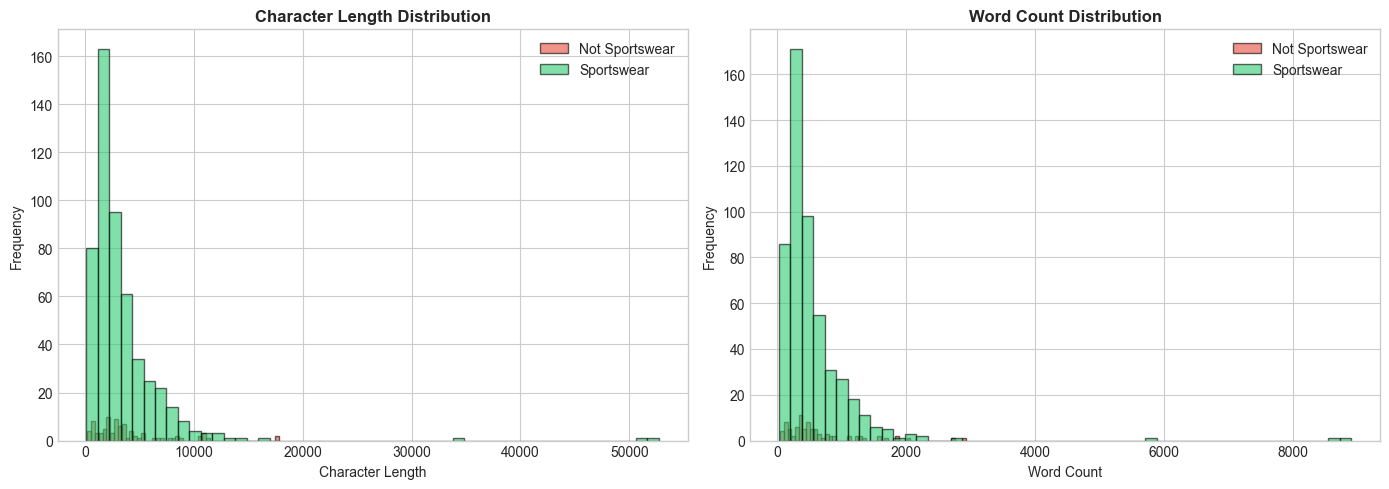

In [11]:
# Plot text length distributions by class (TRAINING DATA ONLY)
plot_text_length_distributions(
    train_df, 'content', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    save_path='images/fp_text_length_dist.png'
)

### 4.2 Brand Distribution

In [12]:
# Analyze brand distribution (TRAINING DATA ONLY)
brand_counts = analyze_brand_distribution(train_df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 645
Unique brands: 40

Top 15 brands:
  Nike: 162 (25.1%)
  Lululemon: 76 (11.8%)
  Puma: 41 (6.4%)
  Adidas: 40 (6.2%)
  Vans: 36 (5.6%)
  Hoka: 28 (4.3%)
  Anta: 28 (4.3%)
  New Balance: 23 (3.6%)
  Reebok: 20 (3.1%)
  Black Diamond: 17 (2.6%)
  Skechers: 17 (2.6%)
  Patagonia: 17 (2.6%)
  Timberland: 15 (2.3%)
  Salomon: 14 (2.2%)
  Converse: 12 (1.9%)

Brand distribution by is_sportswear:
  Class 0: 89 mentions, top: Black Diamond (17), Vans (17), Anta (13)
  Class 1: 556 mentions, top: Nike (161), Lululemon (76), Adidas (40)


Figure saved to images/fp_brand_dist.png


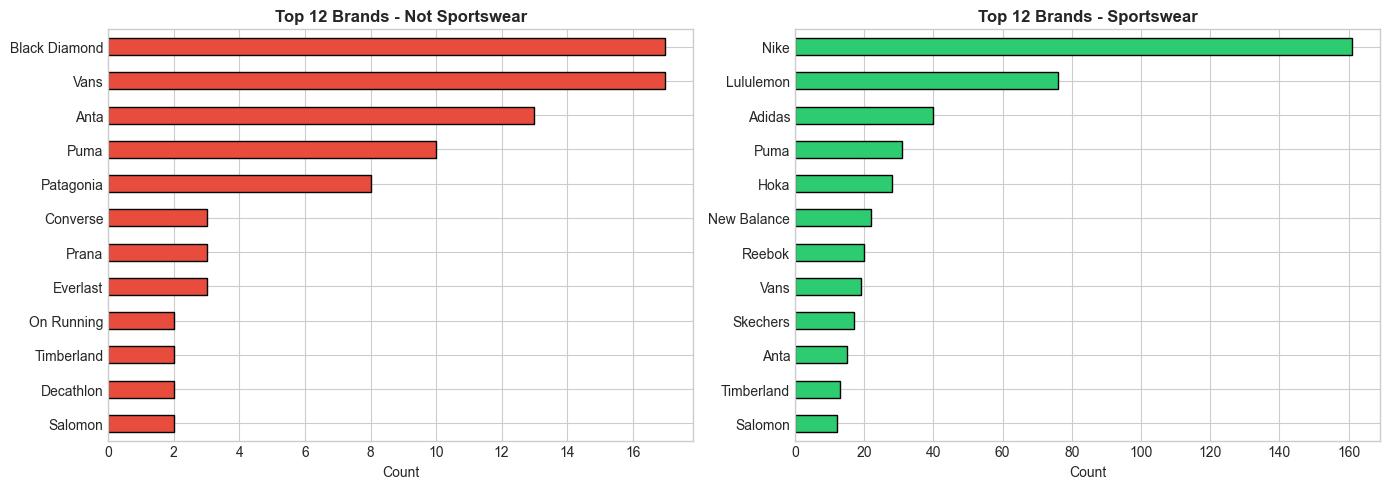

In [13]:
# Plot brand distribution by class (TRAINING DATA ONLY)
plot_brand_distribution(
    train_df, 'brands', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/fp_brand_dist.png'
)

### 4.3 Word Frequency Analysis

In [14]:
# Analyze word frequencies by class (TRAINING DATA ONLY)
word_freqs = analyze_word_frequencies(train_df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  company: 125
  black: 96
  diamond: 92
  curtains: 86
  pvc: 85
  over: 81
  group: 78
  year: 77
  puma: 74
  including: 72
  out: 72
  vans: 70
  like: 65
  people: 64
  gold: 64

Top 15 words for class_1:
  nike: 1,447
  company: 899
  year: 827
  lululemon: 759
  brand: 697
  running: 606
  quarter: 527
  out: 523
  like: 508
  market: 494
  over: 486
  shoe: 472
  stock: 470
  growth: 439
  price: 407


In [15]:
# Look at some false positive examples (TRAINING DATA ONLY)
print("\n" + "="*60)
print("SAMPLE FALSE POSITIVE ARTICLES (from training data)")
print("="*60)

fp_train = train_df[train_df[TARGET_COL] == 0]
if len(fp_train) >= 3:
    fp_samples = fp_train.sample(3, random_state=RANDOM_STATE)
else:
    fp_samples = fp_train

for _, row in fp_samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'fp_reason' in row and pd.notna(row['fp_reason']):
        print(f"Reason: {row['fp_reason']}")
    print("-" * 40)


SAMPLE FALSE POSITIVE ARTICLES (from training data)

Brands: ['Anta']
Title: HAProxy Technologies Announces Availability of HAProxy Community Performance Packages Compiled with ...
Reason: Anta: The article is entirely about HAProxy Technologies and their software load balancer technology. No mention of Anta sportswear company anywhere in the content.
----------------------------------------

Brands: ['Everlast']
Title: Everlast Minerals ( ASX : EV8 ) Insider Buys A$72 , 000 . 00 in Stock...
Reason: Everlast: Article is about Everlast Minerals Ltd (ASX:EV8), a mining/minerals company, not Everlast boxing and fitness equipment brand
----------------------------------------

Brands: ['Black Diamond']
Title: Noah Holdings Hosts Global Black Diamond Summit , Highlights Vision for AI - Driven Global Wealth Ma...
Reason: Black Diamond: Article is about Noah Holdings' 'Black Diamond Summit' - a wealth management conference event name, not Black Diamond Equipment (the climbing gear/outdoor ap

## 5. Feature Engineering Comparison

We compare multiple feature engineering approaches using cross-validation on the training data with a baseline Logistic Regression classifier. This helps us select the best approach before moving to model selection in the next notebook.

In [16]:
# Define feature engineering approaches to compare
fe_configs = {
    'tfidf_word': {
        'method': 'tfidf_word',
        'max_features': 10000,
        'ngram_range': (1, 2),
        'sublinear_tf': True,
    },
    'tfidf_lsa': {
        'method': 'tfidf_lsa',
        'max_features': 10000,
        'lsa_n_components': 100,
    },
    'doc2vec': {
        'method': 'doc2vec',
        'doc2vec_vector_size': 100,
        'doc2vec_min_count': 2,
        'doc2vec_epochs': 40,
        'doc2vec_dm': 1,
    },
    # 'sentence_transformer': {
    #     'method': 'sentence_transformer',
    #     'sentence_model_name': 'all-MiniLM-L6-v2',
    # },
    'sentence_transformer_ner': {
        'method': 'sentence_transformer_ner',
        'sentence_model_name': 'all-MiniLM-L6-v2',
    },
    # 'sentence_transformer_ner_vocab': {
    #     'method': 'sentence_transformer_ner_vocab',
    #     'sentence_model_name': 'all-MiniLM-L6-v2',
    # },
}

print("Feature Engineering Approaches to Compare:")
print("=" * 50)
for name, config in fe_configs.items():
    print(f"  {name}: {config['method']}")

Feature Engineering Approaches to Compare:
  tfidf_word: tfidf_word
  tfidf_lsa: tfidf_lsa
  doc2vec: doc2vec
  sentence_transformer_ner: sentence_transformer_ner


In [17]:
# Evaluate each feature engineering approach using cross-validation
# Compare with both Logistic Regression and HistGradientBoosting classifiers
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Define classifiers to benchmark
# Note: HistGradientBoostingClassifier supports class_weight='balanced' for imbalanced data
# but requires dense arrays (not sparse matrices)
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(
            max_iter=2000,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            solver='saga'
        ),
        'requires_dense': False,  # LR handles sparse matrices
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(
            max_iter=100,
            max_depth=5,
            class_weight='balanced',
            random_state=RANDOM_STATE,
        ),
        'requires_dense': True,  # HGB requires dense arrays
    },
}

fe_results = []

for name, config in fe_configs.items():
    print(f"Evaluating {name}...")
    
    # Create transformer
    transformer = FPFeatureTransformer(**config, random_state=RANDOM_STATE)
    
    # Fit and transform training data with metadata
    X_train_fe = transformer.fit_transform(
        X_train,
        source_names=train_source_names,
        categories=train_categories
    )
    
    print(f"  Feature shape: {X_train_fe.shape}, sparse: {sparse.issparse(X_train_fe)}")
    
    # Evaluate with each classifier
    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        
        # Convert to dense if classifier requires it
        if clf_info['requires_dense'] and sparse.issparse(X_train_fe):
            X_for_cv = X_train_fe.toarray()
        else:
            X_for_cv = X_train_fe
        
        # Cross-validation
        cv_scores = cross_validate(
            clf, X_for_cv, y_train,
            cv=cv,
            scoring={
                'f2': f2_scorer,
                'recall': 'recall',
                'precision': 'precision',
            },
            return_train_score=False
        )
        
        result = {
            'name': name,
            'classifier': clf_name,
            'n_features': X_train_fe.shape[1],
            'cv_f2': cv_scores['test_f2'].mean(),
            'cv_f2_std': cv_scores['test_f2'].std(),
            'cv_recall': cv_scores['test_recall'].mean(),
            'cv_precision': cv_scores['test_precision'].mean(),
        }
        fe_results.append(result)
        
        print(f"  [{clf_name}] CV F2: {result['cv_f2']:.4f} (+/- {result['cv_f2_std']:.4f})")

Evaluating tfidf_word...


  Feature shape: (603, 10008), sparse: True


  [LogisticRegression] CV F2: 0.9381 (+/- 0.0139)


  [HistGradientBoosting] CV F2: 0.9373 (+/- 0.0146)
Evaluating tfidf_lsa...


  Feature shape: (603, 108), sparse: False


  [LogisticRegression] CV F2: 0.9235 (+/- 0.0250)


  [HistGradientBoosting] CV F2: 0.9389 (+/- 0.0095)
Evaluating doc2vec...


  Feature shape: (603, 108), sparse: False


  [LogisticRegression] CV F2: 0.9019 (+/- 0.0155)


  [HistGradientBoosting] CV F2: 0.9486 (+/- 0.0095)
Evaluating sentence_transformer_ner...


  Feature shape: (603, 398), sparse: False


  [LogisticRegression] CV F2: 0.9228 (+/- 0.0163)


  [HistGradientBoosting] CV F2: 0.9534 (+/- 0.0075)


In [18]:
# Compare feature engineering results
fe_df = pd.DataFrame(fe_results)

# Create pivot table for easier comparison
pivot_df = fe_df.pivot_table(
    index='name',
    columns='classifier',
    values=['cv_f2', 'cv_recall', 'cv_precision'],
    aggfunc='first'
)

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPARISON RESULTS")
print("=" * 80)

# Display results sorted by LogisticRegression F2 score
display_df = fe_df[fe_df['classifier'] == 'LogisticRegression'].set_index('name')
display_df = display_df.sort_values('cv_f2', ascending=False)
print("\nLogistic Regression Results:")
print(display_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

# Display HistGradientBoosting results
hgb_df = fe_df[fe_df['classifier'] == 'HistGradientBoosting'].set_index('name')
hgb_df = hgb_df.sort_values('cv_f2', ascending=False)
print("\nHistGradientBoosting Results:")
print(hgb_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

print("=" * 80)

# Determine best overall
best_row = fe_df.loc[fe_df['cv_f2'].idxmax()]
best_fe = best_row['name']
best_clf = best_row['classifier']
print(f"\nBest combination: {best_fe} + {best_clf}")
print(f"  CV F2: {best_row['cv_f2']:.4f}")
print(f"  Features: {int(best_row['n_features'])}")


FEATURE ENGINEERING COMPARISON RESULTS

Logistic Regression Results:
                          n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                   
tfidf_word                     10008  0.938096   0.013946   0.930535   
tfidf_lsa                        108  0.923539   0.025016   0.911245   
sentence_transformer_ner         398  0.922760   0.016321   0.909273   
doc2vec                          108  0.901918   0.015455   0.895763   

                          cv_precision  
name                                    
tfidf_word                    0.970008  
tfidf_lsa                     0.977635  
sentence_transformer_ner      0.981217  
doc2vec                       0.928517  

HistGradientBoosting Results:
                          n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                   
sentence_transformer_ner         398  0.953415   0.007550   0.955617   
doc2

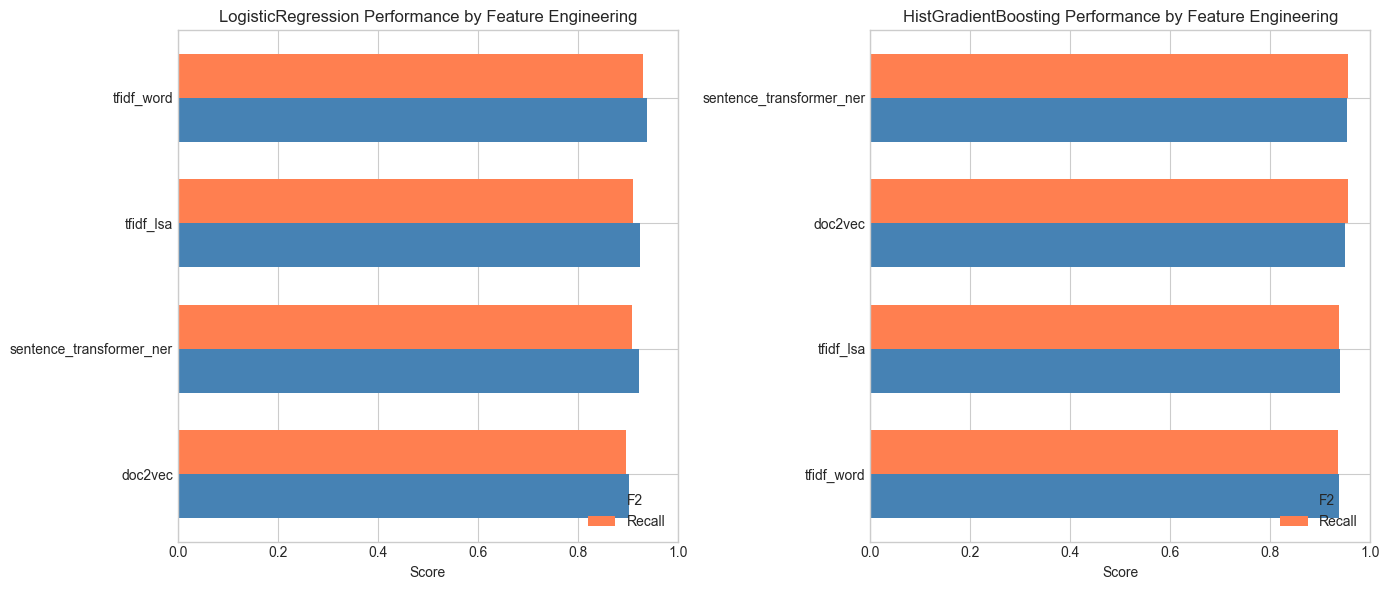

In [19]:
# Visualize comparison - show both classifiers side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, clf_name in enumerate(['LogisticRegression', 'HistGradientBoosting']):
    ax = axes[idx]
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=True)
    
    x = range(len(clf_df))
    width = 0.35
    
    ax.barh([i - width/2 for i in x], clf_df['cv_f2'], width, label='F2', color='steelblue')
    ax.barh([i + width/2 for i in x], clf_df['cv_recall'], width, label='Recall', color='coral')
    
    ax.set_yticks(list(x))
    ax.set_yticklabels(clf_df.index)
    ax.set_xlabel('Score')
    ax.set_title(f'{clf_name} Performance by Feature Engineering')
    ax.legend(loc='lower right')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'fe_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5.1 Feature Transformer Hyperparameter Tuning

Now that we've identified `sentence_transformer_ner` as the best feature engineering approach, we tune its key hyperparameter: `proximity_window_size` - the word window around brand mentions for NER feature extraction.

In [20]:
# Tune proximity_window_size for sentence_transformer_ner
# This controls the word window around brand mentions for NER feature extraction

proximity_values = [10, 15, 20, 25]

# Use HistGradientBoosting as the baseline classifier (best performer)
baseline_clf = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=5,
    class_weight='balanced',
    random_state=RANDOM_STATE,
)

tuning_results = []

print("=" * 70)
print("TUNING proximity_window_size FOR sentence_transformer_ner")
print("=" * 70)
print(f"\nTesting values: {proximity_values}")
print(f"Classifier: HistGradientBoostingClassifier (baseline)")
print(f"CV: {N_FOLDS}-fold stratified\n")

for window_size in proximity_values:
    print(f"Testing proximity_window_size={window_size}...")
    
    # Create transformer with this window size
    transformer = FPFeatureTransformer(
        method='sentence_transformer_ner',
        sentence_model_name='all-MiniLM-L6-v2',
        proximity_window_size=window_size,
        random_state=RANDOM_STATE
    )
    
    # Fit and transform with metadata
    X_train_tuned = transformer.fit_transform(
        X_train,
        source_names=train_source_names,
        categories=train_categories
    )
    
    # Cross-validation
    cv_scores = cross_validate(
        baseline_clf, X_train_tuned, y_train,
        cv=cv,
        scoring={
            'f2': f2_scorer,
            'recall': 'recall',
            'precision': 'precision',
        },
        return_train_score=False
    )
    
    result = {
        'proximity_window_size': window_size,
        'cv_f2': cv_scores['test_f2'].mean(),
        'cv_f2_std': cv_scores['test_f2'].std(),
        'cv_recall': cv_scores['test_recall'].mean(),
        'cv_precision': cv_scores['test_precision'].mean(),
    }
    tuning_results.append(result)
    
    print(f"  CV F2: {result['cv_f2']:.4f} (+/- {result['cv_f2_std']:.4f})")

print("\n" + "=" * 70)

TUNING proximity_window_size FOR sentence_transformer_ner

Testing values: [10, 15, 20, 25]
Classifier: HistGradientBoostingClassifier (baseline)
CV: 3-fold stratified

Testing proximity_window_size=10...


  CV F2: 0.9550 (+/- 0.0064)
Testing proximity_window_size=15...


  CV F2: 0.9534 (+/- 0.0075)
Testing proximity_window_size=20...


  CV F2: 0.9526 (+/- 0.0048)
Testing proximity_window_size=25...


  CV F2: 0.9541 (+/- 0.0070)



In [21]:
# Analyze tuning results and select best proximity_window_size
tuning_df = pd.DataFrame(tuning_results)
tuning_df = tuning_df.sort_values('cv_f2', ascending=False)

print("PROXIMITY_WINDOW_SIZE TUNING RESULTS")
print("=" * 70)
print(tuning_df.to_string(index=False))

# Find best value
best_idx = tuning_df['cv_f2'].idxmax()
optimal_proximity_window = int(tuning_df.loc[best_idx, 'proximity_window_size'])
best_proximity_f2 = tuning_df.loc[best_idx, 'cv_f2']
default_f2 = tuning_df[tuning_df['proximity_window_size'] == 15]['cv_f2'].values[0]

print("\n" + "=" * 70)
print(f"Optimal proximity_window_size: {optimal_proximity_window}")
print(f"Best CV F2: {best_proximity_f2:.4f}")
print(f"Default (15) CV F2: {default_f2:.4f}")
print(f"Improvement: {(best_proximity_f2 - default_f2) * 100:+.2f}%")
print("=" * 70)

PROXIMITY_WINDOW_SIZE TUNING RESULTS
 proximity_window_size    cv_f2  cv_f2_std  cv_recall  cv_precision
                    10 0.954973   0.006442   0.957544      0.944866
                    25 0.954146   0.006966   0.955617      0.948410
                    15 0.953415   0.007550   0.955617      0.944757
                    20 0.952581   0.004754   0.953679      0.948331

Optimal proximity_window_size: 10
Best CV F2: 0.9550
Default (15) CV F2: 0.9534
Improvement: +0.16%


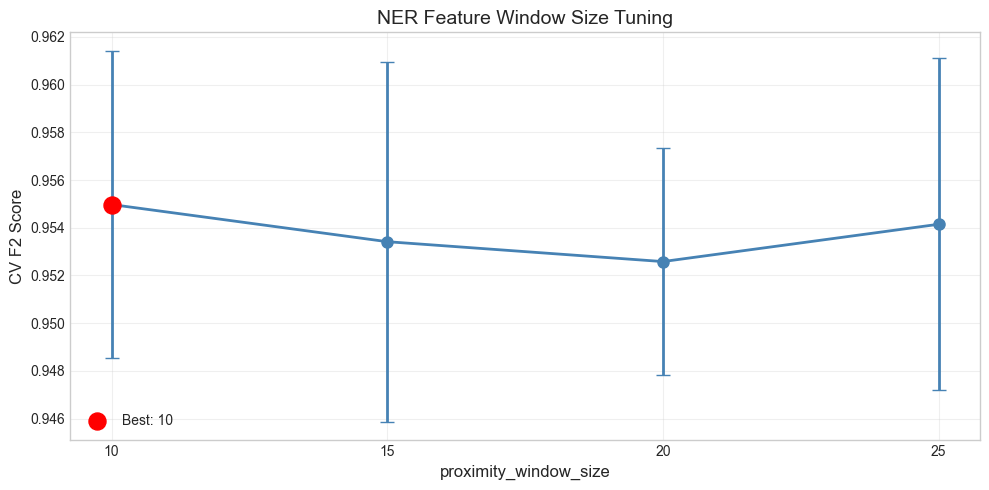

In [22]:
# Visualize proximity_window_size tuning results
fig, ax = plt.subplots(figsize=(10, 5))

# Sort by window size for plotting
plot_df = tuning_df.sort_values('proximity_window_size')

ax.errorbar(
    plot_df['proximity_window_size'], 
    plot_df['cv_f2'], 
    yerr=plot_df['cv_f2_std'],
    marker='o', 
    markersize=8,
    capsize=5,
    linewidth=2,
    color='steelblue'
)

# Highlight best value
ax.scatter([optimal_proximity_window], [best_proximity_f2], s=150, c='red', zorder=5, label=f'Best: {optimal_proximity_window}')

ax.set_xlabel('proximity_window_size', fontsize=12)
ax.set_ylabel('CV F2 Score', fontsize=12)
ax.set_title('NER Feature Window Size Tuning', fontsize=14)
ax.set_xticks(proximity_values)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'proximity_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Pipeline Export

Create and export the best feature transformer for use in the model selection notebook.

In [23]:
# Create the best transformer with optimal hyperparameters from tuning
print(f"Selected feature engineering approach: {best_fe}")
print(f"Base configuration: {fe_configs[best_fe]}")
print(f"Optimal proximity_window_size: {optimal_proximity_window}")

# Create transformer with best configuration INCLUDING tuned hyperparameters
final_transformer = FPFeatureTransformer(
    **fe_configs[best_fe],
    proximity_window_size=optimal_proximity_window,
    random_state=RANDOM_STATE
)

# Fit on training data with metadata
X_train_final = final_transformer.fit_transform(
    X_train,
    source_names=train_source_names,
    categories=train_categories
)
print(f"\nFinal feature shape: {X_train_final.shape}")
print(f"Transformer config: proximity_window_size={final_transformer.proximity_window_size}")
print(f"Metadata features enabled: {final_transformer.include_metadata_features}")
print(f"Metadata scaler fitted: {final_transformer._metadata_scaler is not None}")

# Verify by transforming validation data
X_val_final = final_transformer.transform(
    X_val,
    source_names=val_source_names,
    categories=val_categories
)
print(f"Validation feature shape: {X_val_final.shape}")

Selected feature engineering approach: sentence_transformer_ner
Base configuration: {'method': 'sentence_transformer_ner', 'sentence_model_name': 'all-MiniLM-L6-v2'}
Optimal proximity_window_size: 10



Final feature shape: (603, 398)
Transformer config: proximity_window_size=10
Metadata features enabled: True
Metadata scaler fitted: True


Validation feature shape: (201, 398)


In [24]:
# Save the fitted transformer
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
joblib.dump(final_transformer, transformer_path)
print(f"Transformer saved to: {transformer_path}")

# Save configuration for reproducibility
config_path = MODELS_DIR / 'fp_feature_config.json'
final_transformer.save_config(config_path)
print(f"Configuration saved to: {config_path}")

# Also save the comparison results
results_path = MODELS_DIR / 'fp_fe_comparison.json'
with open(results_path, 'w') as f:
    json.dump(fe_results, f, indent=2)
print(f"Comparison results saved to: {results_path}")

Transformer saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
Comparison results saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json


## 7. Summary

In [25]:
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} articles")
print(f"  - Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"\nClass distribution (training):")
print(f"  - Sportswear: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  - False Positive: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"\nBest Feature Engineering: {best_fe}")
print(f"  - Best Classifier: {best_clf}")
print(f"  - CV F2 Score: {best_row['cv_f2']:.4f}")
print(f"  - Features: {int(best_row['n_features'])}")
print(f"  - Optimal proximity_window_size: {optimal_proximity_window}")
print(f"\nArtifacts saved:")
print(f"  - {MODELS_DIR / 'fp_feature_transformer.joblib'}")
print(f"  - {MODELS_DIR / 'fp_feature_config.json'}")
print(f"  - {MODELS_DIR / 'fp_fe_comparison.json'}")
print(f"\nNext: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning")
print("=" * 60)

NOTEBOOK SUMMARY

Dataset: 1005 articles
  - Training: 603 (60.0%)
  - Validation: 201 (20.0%)

Class distribution (training):
  - Sportswear: 518 (85.9%)
  - False Positive: 85 (14.1%)

Best Feature Engineering: sentence_transformer_ner
  - Best Classifier: HistGradientBoosting
  - CV F2 Score: 0.9534
  - Features: 398
  - Optimal proximity_window_size: 10

Artifacts saved:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json

Next: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning
